# Implementing Faster R-CNN

The objective of this activity is to implement the main parts of the Faster R-CNN algorithm. We'll use pre-trained weights to guide and facilitate the process, and implement all the stages one by one.

We've tried to keep code in the notebooks to a minimum, mainly data manipulation and visualization, to make it easy enough to follow. All accompanying code is under the `workshop` Python package.

After some introductory code, the notebook will continue as follows:
* Playing with a **pre-trained Resnet** to obtain features out of an image.
* Generate regions of interest by implementing the **Region Proposal Network** detailed in [1].
* Prepare this regions to be fed to the second stage, by applying **RoI pooling**.
* Classify and refine said networks by passing them through an **R-CNN**, as detailed in [2].

We'll present you with stubs for the different functions required and your task will be to fill them in.

Note that, due to time constraints, we won't actually implement anything relating to training the model itself. We'll be focusing on the required machinery for inference, and give some pointers on what's missing to train it from scratch.

* [1] Ren, Shaoqing, et al. *Faster R-CNN: Towards real-time object detection with region proposal networks.*
* [2] Girshick, Ross. *Fast R-CNN.*

---
# The basics
We'll start with some imports.

The local imports are under the `workshop` package, which you should have installed using `pip install -e workshop/` in the virtualenv you're running your notebook on. [Remove if we're going to use Azure.]

Within `workshop` we have some modules:
* `vis`: various visualization utilities to draw bounding boxes, sliders, etc.
* `image`: utilities for reading images and loading them into PIL (the imaging library).
* `resnet`: the implementation for the base network we're going to use (more on this shortly).
* `faster`: utilities and parts we won't be implementing but provide for completeness' sake.

Let's test some things to make sure everything is up and ready to go.

Start by running the following in your terminal, and then test the rest of the imports:
```bash
 $ jupyter nbextension enable --py --sys-prefix widgetsnbextension
 ```

In [33]:
from ipywidgets import interact, FloatSlider, IntSlider, Layout

import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from PIL import Image


# Try to enable TF eager execution, or do nothing if running again.
try:
    tf.enable_eager_execution()
except ValueError:
    # Already executed.
    pass


# Local imports.
from workshop.faster import run_base_network, clip_boxes, get_width_upright, rcnn_proposals
from workshop.image import open_all_images, open_image, to_image
from workshop.resnet import resnet_v1_101, resnet_v1_101_tail
from workshop.vis import image_grid, draw_bboxes, draw_bboxes_with_labels

# Notebook-specific settings.
%matplotlib inline

We'll now load some images to play with and display them below. Change which image is passed to the `to_image` function to see it in full size.

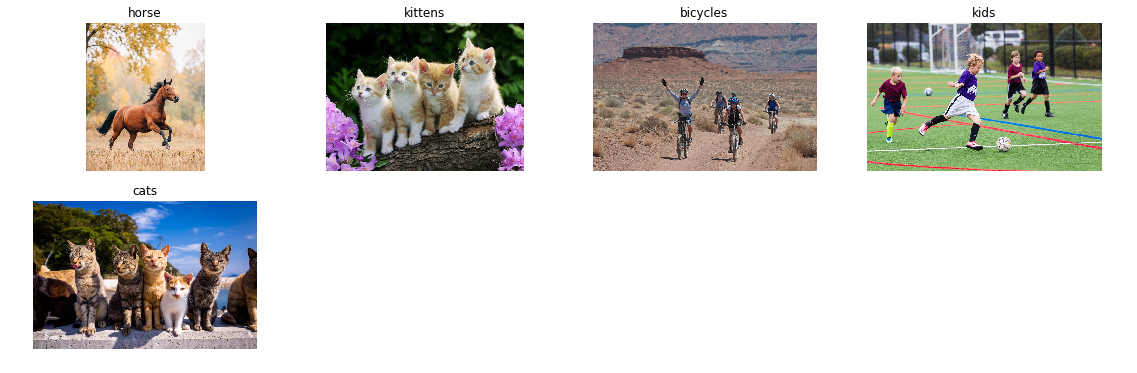

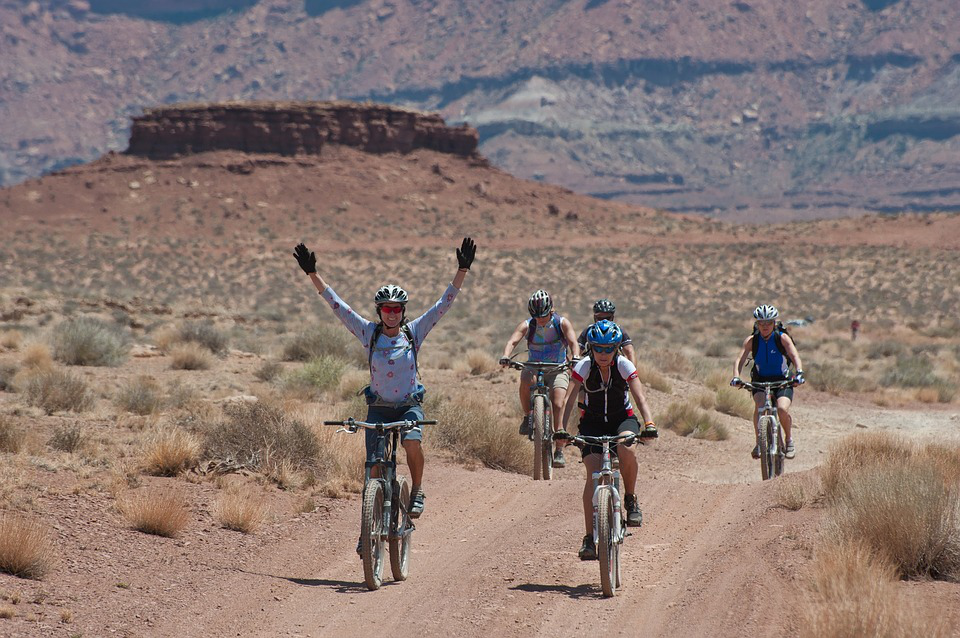

In [2]:
images = open_all_images('images/')

axes = image_grid(len(images))
for ax, (name, image) in zip(axes, images.items()):
    ax.imshow(np.squeeze(image))
    ax.set_title(name)

plt.subplots_adjust(wspace=.01)
plt.show()

image = images['bicycles']

# `to_image` turns a `numpy.ndarray` into a PIL image, so it's displayed by the notebook.
to_image(image)

---
# The base network: ResNet


The basis for the Faster R-CNN algorithm is to leverage a pre-trained classifier network to extract feature maps (also called *activation maps*) from the image. For this implementation, we'll be using the popular ResNet 101 [3].

We provide the implementation itself (which you can see in the `workshop.resnet` module), as well as a checkpoint with the weights (in the `checkpoint/` directory).

Run the base network on different images, in order to see how the different feature maps behave. **Can you notice any particular features being detected in the activation maps?**

* [3] He, Kaiming, et al. *Deep residual learning for image recognition.*

In [3]:
with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    feature_map = run_base_network(image)

In [4]:
per_page = 20

slider = IntSlider(
    min=0, max=1024 // per_page, value=0,
    description='Feature map',
    layout=Layout(width='600px')
)

@interact(page=slider)
def display_feature_maps(page):
    axes = image_grid(per_page)
    for idx, ax in enumerate(axes):
        ax.imshow(
            feature_map.numpy()[0, :, :, page * per_page + idx],
            cmap='gray', aspect='auto'
        )

    plt.subplots_adjust(wspace=.01, hspace=.01)
    plt.show()

Let's overlay the feature maps into the image themselves, so we can take a more detailed look into what feature of the image the ResNet reacts to.

See, for example:
* Feature maps 19, 22 in `cats`.
* Feature map 34, 64 in `bicycles`.

In [5]:
slider = IntSlider(
    min=0, max=1024, value=0,
    description='Feature map index',
    layout=Layout(width='600px')
)

@interact(idx=slider)
def overlay_feature_map(idx=0):
    # Normalize the feature map so we get the whole range of colors.
    fm = (
        feature_map.numpy()[0, :, :, idx]
        / feature_map.numpy()[0, :, :, idx].max()
        * 255
    ).astype(np.uint8)
    
    fm_image = Image.fromarray(fm, mode='L').convert('RGBA')
    fm_image = fm_image.resize(
        image.shape[1:3][::-1],
        resample=Image.NEAREST
    )
    
    # Add some alpha to overlay it over the image.
    fm_image.putalpha(200)
    
    base_image = to_image(image)
    base_image.paste(fm_image, (0, 0), fm_image)
    
    return base_image

This section didn't require any implementation at all, but get ready, because we're about to. The main idea here was illustrating what we mean when we say that the later layers of a classification network are **feature detectors**, reacting to particular structures in an image.

What would you do if you were to use this information to detect objects? How could you leverage the fact that we can say "there's a cat ear here!"? We're going to explore these questions in the following sections.

For now, back to the slides!

---
# Finding stuff with the Region Proposal Network

Having gone through the theory, we'll now turn our attention to implementing a **Region Proposal Network**. The idea, as we've seen, is to use the feature maps provided by the ResNet to find out **where** there might be an object located.

This is where **anchors** come into play. We'll take a grid of points over the image and consider several (15, in this case) anchors, or reference boxes, for each of them. The RPN layers themselves will then predict whether there's an object in each of these 15 boxes **and** how much we need to resize them to better fit it.

The tasks we have ahead of us are, thus:
* Get the **coordinates** $(x_{min}, y_{min}, x_{max}, y_{max})$ for each of the anchors. There are $15$ anchors and the centers will be separated by approximately $16$ pixels, so we're talking about several thousands of coordinates.
* Find out how to do the special **encoding and decoding** of coordinates described in Faster R-CNN so the RPN can predict locations in the image.
* Build the **convolutional layers** comprising the RPN and run them through different images.
* **Translate the predictions** of the RPN layer into usable proposals.

## Generating anchors

We'll get the anchor's coordinates in two steps. First we'll implement the `generate_anchors_reference` function which will return, given the anchors' settings (i.e. size, aspect ratio, scales), the coordinates for said boxes (in pixel space) assuming they're centered around (0, 0). This will give us, effectively, a $(15, 4)$ array.

Then, we'll sum those coordinates to each of the **anchor centers** of the image in the function `generate_anchors`. Given that we're using a ResNet 101, which has a downsampling factor of 16 (i.e. every point in the final feature map corresponds to a $16\times16$ region of the original image), we'll select the centers every 16 pixels in each direction.

Go on and implement `generate_anchors_reference`, and check that the output makes sense. You can try varying the anchor settings to see if it still makes sense.

In [72]:
def generate_anchors_reference(base_size, aspect_ratios, scales):
    """Generate base set of anchors to be used as reference for all anchors.

    Anchors vary only in width and height. Using the base_size and the
    different ratios we can calculate the desired widths and heights.

    Aspect ratios maintain the area of the anchors, while scales apply to the
    length of it (and thus affect it squared).

    Args:
        base_size (int): Base size of the base anchor (square).
        aspect_ratios: Ratios to use to generate different anchors. The ratio
            is the value of height / width.
        scales: Scaling ratios applied to length.

    Returns:
        anchors: Numpy array with shape (total_aspect_ratios * total_scales, 4)
            with the corner points of the reference base anchors using the
            convention (x_min, y_min, x_max, y_max).
    """
    
    # See: np.meshgrid, np.stack (no son imprescindibles).
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    scales_grid, aspect_ratios_grid = np.meshgrid(scales, aspect_ratios)
    base_scales = scales_grid.reshape(-1)
    base_aspect_ratios = aspect_ratios_grid.reshape(-1)

    aspect_ratio_sqrts = np.sqrt(base_aspect_ratios)
    heights = base_scales * aspect_ratio_sqrts * base_size
    widths = base_scales / aspect_ratio_sqrts * base_size

    # Center point has the same X, Y value.
    center_xy = 0

    # Create anchor reference.
    anchors = np.column_stack([
        center_xy - (widths - 1) / 2,
        center_xy - (heights - 1) / 2,
        center_xy + (widths - 1) / 2,
        center_xy + (heights - 1) / 2,
    ])

    real_heights = (anchors[:, 3] - anchors[:, 1]).astype(np.int)
    real_widths = (anchors[:, 2] - anchors[:, 0]).astype(np.int)

    ####
    
    return anchors


references = generate_anchors_reference(
    256,  # Base size.
    [0.5, 1, 2],  # Aspect ratios.
    [0.125, 0.25, 0.5, 1, 2],  # Scales.
)

print('Anchor references (real image size):')
print()
print(references)

Anchor references (real image size):

[[ -22.127417    -10.8137085    22.127417     10.8137085 ]
 [ -44.754834    -22.127417     44.754834     22.127417  ]
 [ -90.00966799  -44.754834     90.00966799   44.754834  ]
 [-180.51933598  -90.00966799  180.51933598   90.00966799]
 [-361.53867197 -180.51933598  361.53867197  180.51933598]
 [ -15.5         -15.5          15.5          15.5       ]
 [ -31.5         -31.5          31.5          31.5       ]
 [ -63.5         -63.5          63.5          63.5       ]
 [-127.5        -127.5         127.5         127.5       ]
 [-255.5        -255.5         255.5         255.5       ]
 [ -10.8137085   -22.127417     10.8137085    22.127417  ]
 [ -22.127417    -44.754834     22.127417     44.754834  ]
 [ -44.754834    -90.00966799   44.754834     90.00966799]
 [ -90.00966799 -180.51933598   90.00966799  180.51933598]
 [-180.51933598 -361.53867197  180.51933598  361.53867197]]


A good way to check if the implementation is correct is just drawing them and making sure the result makes sense. If the image is too chaotic, you can try decreasing the number of scales and aspect ratios, but do revert it back before continuing.

Remember: for scales, length is doubled, for aspect ratios, the area is maintained.

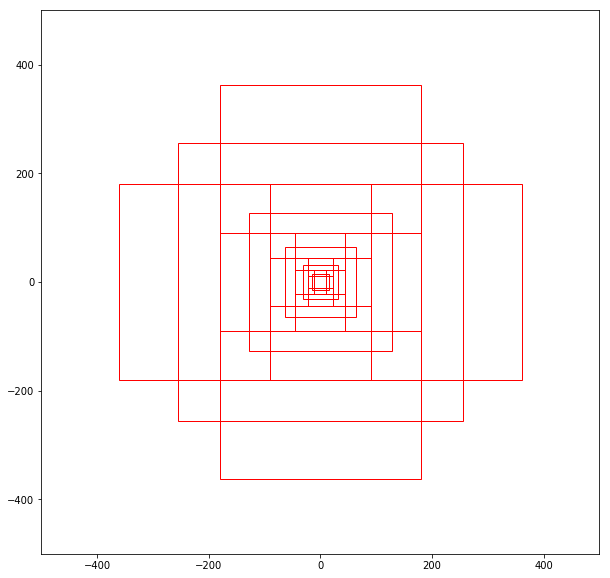

In [74]:
fig, ax = plt.subplots(1, figsize=(10, 10))

for ref_idx in range(references.shape[0]):
    x_min, y_min, x_max, y_max = references[ref_idx, :]
    rect = matplotlib.patches.Rectangle(
        (x_min, -y_max),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])

plt.show()

And for reference, let's draw one over `image`, to see how they match. Since the anchor references are centered around $(0, 0)$, we can sum $P = (x_p, y_p)$ to get the references at $P$.

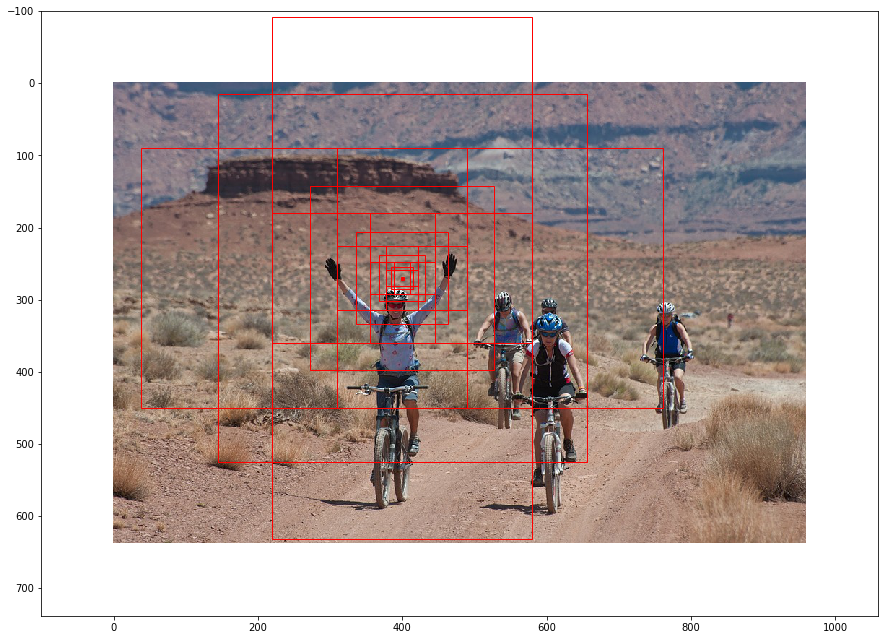

In [52]:
### TODO: Fix/clarify y-coordinate issues.
point = np.array([400, -270])

p_min, p_max = references[:, :2], references[:, 2:]

p_references = np.concatenate([point + p_min, point + p_max], axis=1)

fig, ax = plt.subplots(1, figsize=(15, 20))

ax.imshow(to_image(image))
ax.set_xlim([-100, image.shape[2] + 100])
ax.set_ylim([image.shape[1] + 100, -100])

for ref_idx in range(p_references.shape[0]):
    x_min, y_min, x_max, y_max = p_references[ref_idx, :]
    rect = matplotlib.patches.Rectangle(
        (x_min, -y_max),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

# Plot the reference point in use.
ax.plot(point[0], -point[1], marker='s', color='red', markersize=3)

plt.show()

As you can see, the larger boxes cover quite a bit of the image, while the smaller ones will be useful for detecting very small objects.

Now, as we said before, we want the above for all **anchor centers**, which we said were going to be located every 16 pixels. For reference, the anchor centers are visualized below.

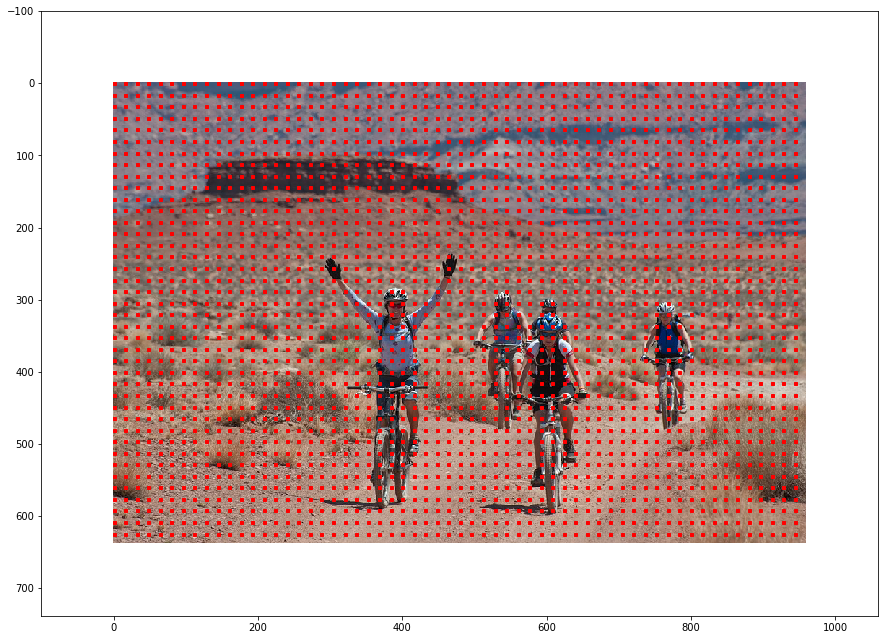

In [9]:
# TODO: See where this should be set. Is actually dependent on the base network.
OUTPUT_STRIDE = 16


# Print the anchor centers in use.

fig, ax = plt.subplots(1, figsize=(15, 20))

ax.imshow(to_image(image))
ax.set_xlim([-100, image.shape[2] + 100])
ax.set_ylim([image.shape[1] + 100, -100])

for x in range(0, image.shape[2], OUTPUT_STRIDE):
    for y in range(0, image.shape[1], OUTPUT_STRIDE):
        ax.plot(x, y, marker='s', color='red', markersize=3)

plt.show()

Let's wrap up this part by getting the entire list of anchors for the image. This will be done within te `generate_anchors` function.

In [37]:
# TODO: Document.
ANCHOR_BASE_SIZE = 256
ANCHOR_RATIOS = [0.5, 1, 2]
ANCHOR_SCALES = [0.125, 0.25, 0.5, 1, 2]


def generate_anchors(feature_map_shape):
    """Generate anchors for an image.

    Using the feature map (the output of the pretrained network for an image)
    and the anchor references (generated using the specified anchor sizes and
    ratios), we generate a list of anchors.

    Anchors are just fixed bounding boxes of different ratios and sizes that
    are uniformly generated throught the image.

    Args:
        feature_map_shape: Shape of the convolutional feature map used as
            input for the RPN. Should be (batch, height, width, depth).

    Returns:
        all_anchors: A flattened Tensor with all the anchors of shape
            `(num_anchors_per_points * feature_width * feature_height, 4)`
            using the (x1, y1, x2, y2) convention.
    """

    anchor_reference = generate_anchors_reference(
        ANCHOR_BASE_SIZE, ANCHOR_RATIOS, ANCHOR_SCALES
    )
    
    # See tf.meshgrid, tf.range, tf.expand_dims.
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    with tf.variable_scope('generate_anchors'):
        grid_width = feature_map_shape[2]  # width
        grid_height = feature_map_shape[1]  # height
        shift_x = tf.range(grid_width) * OUTPUT_STRIDE
        shift_y = tf.range(grid_height) * OUTPUT_STRIDE
        shift_x, shift_y = tf.meshgrid(shift_x, shift_y)

        shift_x = tf.reshape(shift_x, [-1])
        shift_y = tf.reshape(shift_y, [-1])

        shifts = tf.stack(
            [shift_x, shift_y, shift_x, shift_y],
            axis=0
        )

        shifts = tf.transpose(shifts)
        # Shifts now is a (H x W, 4) Tensor

        # Expand dims to use broadcasting sum.
        all_anchors = (
            np.expand_dims(anchor_reference, axis=0) +
            tf.expand_dims(shifts, axis=1)
        )

        # Flatten
        all_anchors = tf.reshape(
            all_anchors, (-1, 4)
        )
    
    ####

    return all_anchors


anchors = generate_anchors(feature_map.shape)

print('Anchors (real image size):')
print()
print(anchors.numpy())

Anchors (real image size):

[[ -22  -10   22   10]
 [ -44  -22   44   22]
 [ -90  -44   90   44]
 ...
 [ 900  534  988  714]
 [ 854  444 1034  804]
 [ 764  263 1124  985]]


Let's get three or four anchors to corroborate that the results makes sense.

In [56]:
# Visualize.

With this we've finished generating the anchors that will be used by the RPN. This is, effectively, a list of $15 \times F_x \times F_y$, where $F_x, F_y$ are the feature map width and height, respectively.

---
## Encoding and decoding coordinates


Deep neural networks usually train and converge better when their outputs have zero mean and unit variance (and/or their intermediate values do so). Due to this, and the difficulty in predicting values in a possibly unbounded region (pixel coordinates), a special encoding is applied to the coordinates before passing them in to the network (and after getting them out).

The idea behind the encoding is to express the coordinates of a bounding box $B$ as a set of four numbers $(D_x, D_y, D_w, D_h)$ (the **deltas**) and a reference bounding box $R$. $D_x$ and $D_y$ indicate how much the center of $R$ should be moved to reach the center of $B$, normalized by the size of $B$, while $D_w$ and $D_h$ indicate how much the width and height of $B$ must be increased or decreased to reach the size of $B$ (it's actually the log of that value, but we'll get into it).

We'll implement two functions here, `encode` and `decode`. While only the latter will be used, it's useful to implement both in order to understand the whole process and to make it easier to test.

[leer paper de esta sección]
[reescribir un poco esta parte]

Formulas (poner paper fragment?):

(Ver paper Faster-RCNN, sección 3.1.2)

In [59]:
# You might find the `get_width_upright` function useful to obtain the 
# [complete]

get_width_upright?

In [11]:
   
def encode(bboxes, references):
    """Encode bounding boxes as deltas w.r.t. reference boxes.

    Arguments:
        proposals: Tensor of shape (total_proposals, 4). Having the bbox
            encoding in the (x_min, y_min, x_max, y_max) order.
        references: Tensor of shape (total_proposals, 4). With the same bbox
            encoding.

    Returns:
        targets: Tensor of shape (total_proposals, 4) with the different
            deltas needed to transform the proposal to `references`. These
            deltas are with regards to the center, width and height of the
            two boxes.
    """

    # TODO: Shouldn't be called gt_boxes but "references".
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (
        bboxes_width, bboxes_height, bboxes_urx, bboxes_ury
    ) = get_width_upright(bboxes)

    (
        ref_boxes_width, ref_boxes_height, ref_boxes_urx, ref_boxes_ury
    ) = get_width_upright(references)

    targets_dx = (ref_boxes_urx - bboxes_urx) / bboxes_width
    targets_dy = (ref_boxes_ury - bboxes_ury) / bboxes_height

    targets_dw = tf.log(ref_boxes_width / bboxes_width)
    targets_dh = tf.log(ref_boxes_height / bboxes_height)

    targets = tf.concat([
        targets_dx, targets_dy, targets_dw, targets_dh
    ], axis=1)

    ####

    return targets


# Test encoding.

In [12]:
def decode(roi, deltas):
    """
    TODO: Docstring plus param name change.
    """        
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (
        roi_width, roi_height, roi_urx, roi_ury
    ) = get_width_upright(roi)

    dx, dy, dw, dh = tf.split(deltas, 4, axis=1)

    pred_ur_x = dx * roi_width + roi_urx
    pred_ur_y = dy * roi_height + roi_ury
    pred_w = tf.exp(dw) * roi_width
    pred_h = tf.exp(dh) * roi_height

    bbox_x1 = pred_ur_x - 0.5 * pred_w
    bbox_y1 = pred_ur_y - 0.5 * pred_h

    # This -1. extra is different from reference implementation.
    # TODO: What does this do?
    bbox_x2 = pred_ur_x + 0.5 * pred_w - 1.
    bbox_y2 = pred_ur_y + 0.5 * pred_h - 1.

    bboxes = tf.concat([
        bbox_x1, bbox_y1, bbox_x2, bbox_y2
    ], axis=1)

    ####

    return bboxes
    
    
# Test decoding.

In [13]:
# Test roundtrip.

---

## Convolutional layers

We now have a variable-size feature map (with a factor of 16 times smaller than the original image) and we want to predict, for each of them, how to modify (i.e. the $4$ values from above, $D_{x, y, w, h}$) each of the $k = 15$ anchors. In this context, it makes sense, then, to use a convolutional layer (or more) on the feature map, where the final number of filters will be $4 \times k$.

For each of these anchors we'll also want to decide whether we think there's an object present on said region or not (thus, $2 \times k$ more filters). This will, in essence, look at the activation maps we saw before and decide whether, in a given region, the activated features amount to an object being in there (e.g. many cat ear features have activated).

As we saw in the slides, the RPN first has a $3\times3$ convolutional layer with $512$ filters and then two outputs heads:
* One with $2 \times k$ filters for the **objectness score**.
* One with $4 \times k$ filters for the **encoded deltas**.

Both will be implemented as $1 \times 1$ convolutions in order to support variable-size images.

In [41]:
# Note that when implementing Faster R-CNN for training, we should
# also specify initializers and regularizers for the weights. We're
# omitting them here for brevity.

def build_rpn(feature_map):
    """Run the RPN layers through the feature map.
    
    Will run the input through an initial convolutional layer of
    filter size 3x3 and 512 channels, using the ReLU6 activation.
    The output of this layer has the same spatial size as the
    input.
    
    Then run two 1x1 convolutions over this intermediate layer, one
    for the resizings and one for the objectness probabilities.
    Remember to apply the softmax activation over the objectness
    scores to get a distribution.
    
    Arguments:
        feature_map: Tensor of shape (1, W, H, C), with WxH the
            spatial shape of the feature map and C the number of
            channels (1024 in this case).
            
    Returns:
        Tuple of Tensors: the first being the output of the bbox
        resizings `(W * H * num_anchors, 4)` and the second being
        the objectness score, of size `(W * H * num_anchors, 2)`.
    """
    
    # Note: see the functions `tf.layers.conv2d` and `tf.reshape`. Also,
    # read the docstring thoroughly to help you pass the correct
    # parameters to the conv layers.
    
    # The names of the layers should be: `rpn/conv` for the base layer,
    # `rpn/cls_conv` for the objectness score, and `rpn/bbox_conv` for
    # the bbox resizing.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    rpn_conv = tf.layers.conv2d(
        feature_map,
        filters=512,
        kernel_size=[3, 3],
        activation=tf.nn.relu6,
        padding='same',
        name='rpn/conv',
    )

    num_anchors = len(ANCHOR_RATIOS) * len(ANCHOR_SCALES)
    rpn_cls = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 2,
        kernel_size=[1, 1],
        name='rpn/cls_conv',
    )
    rpn_cls_score = tf.reshape(rpn_cls, [-1, 2])
    rpn_cls_prob = tf.nn.softmax(rpn_cls_score)

    rpn_bbox = tf.layers.conv2d(
        rpn_conv,
        filters=num_anchors * 4,
        kernel_size=[1, 1],
        name='rpn/bbox_conv',
    )
    rpn_bbox_pred = tf.reshape(rpn_bbox, [-1, 4])
    
    ####

    return rpn_bbox_pred, rpn_cls_prob


with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    rpn_bbox_pred, rpn_cls_prob = build_rpn(feature_map)

Let's plot a histogram of the bounding box modifications for our current image.

Look at the results. Do they make sense? Does it seem that the encoding is indeed helping unbias the predictions? What do values near zero mean?

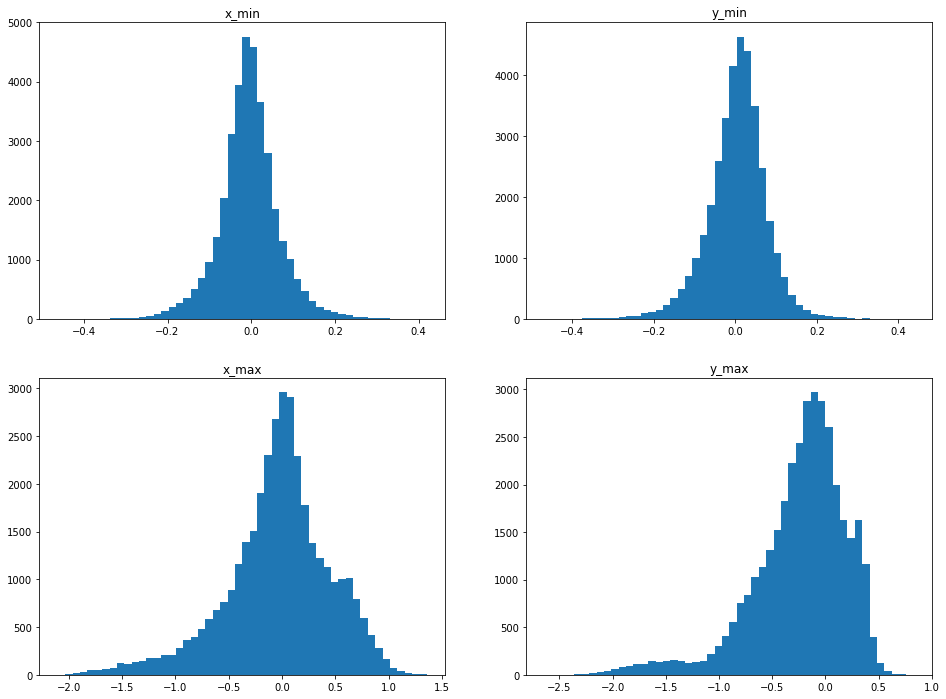

In [61]:
preds = rpn_bbox_pred.numpy()

_, axes = plt.subplots(2, 2, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    title = ['x_min', 'y_min', 'x_max', 'y_max'][idx]
    ax.set_title(title)
    ax.hist(preds[:, idx], bins=50)
    
plt.show()

Let's also plot the objectness scores. As you'll see, most of the anchors are deemed not worthy.

284 predictions over 0.9, out of a total of 36000



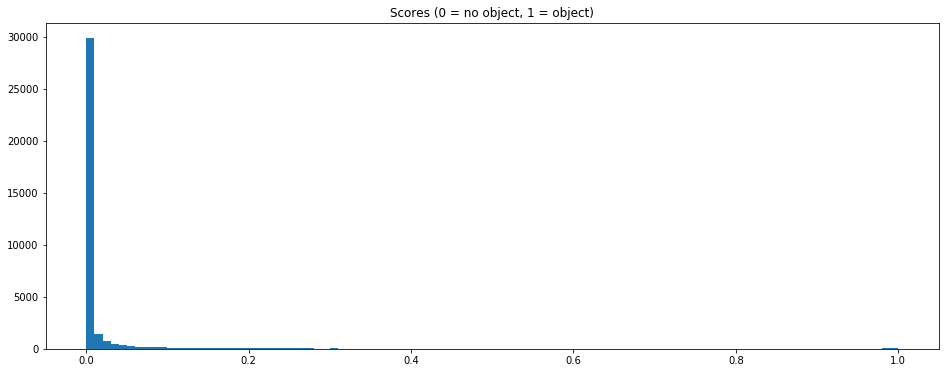

In [44]:
preds = rpn_cls_prob.numpy()[:, 1]

_, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.set_title('Scores (0 = no object, 1 = object)')
ax.hist(preds, bins=100)

print('{} predictions over 0.9, out of a total of {}'.format(
    len(np.flatnonzero(preds > 0.9)), len(preds)
))
print()
    
plt.show()

If you have time, it may prove insightful to analyze other statistics, such as the objectness and/or resizing by anchor size, or by position in the image. Performing an analysis like this can help pick hyperparameters, guide improvements for the algorithms and find pathologies on the architecture.

---
## Generating and filtering proposals

We have the output, now let's do something with it.

In [45]:
# Generate proposals from the RPN's output by decoding the bounding boxes
# according to the configured anchors.
proposals = decode(anchors, rpn_bbox_pred)

# Get the (positive-object) scores from the RPN.
# TODO: Could be just one dimension, right? (If not for compatibility.)
scores = tf.reshape(rpn_cls_prob[:, 1], [-1])

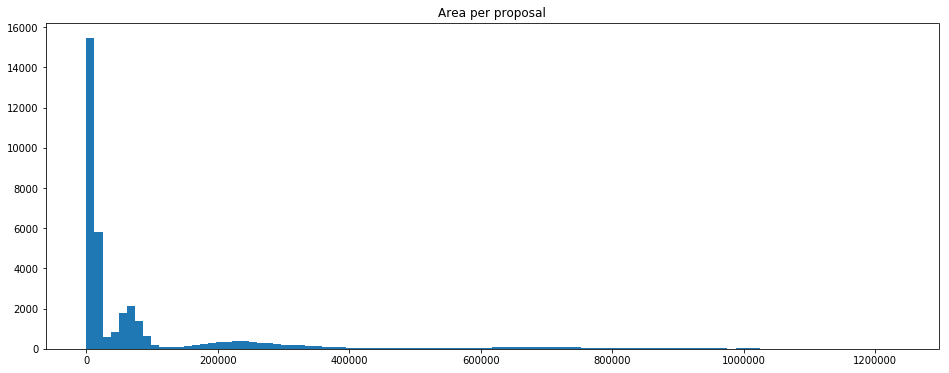

Proposals with areas under zero:
[]


In [46]:
props = proposals.numpy()
areas = (props[:, 2] - props[:, 0]) * (props[:, 3] - props[:, 1])

_, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.set_title('Area per proposal')
ax.hist(areas, bins=100)

plt.show()

print('Proposals with areas under zero:')
print(np.flatnonzero(areas <= 0))

# TODO: Why isn't there any?
# Note: ~250k is 250x100, the average size of the cats here.

In [47]:
# Filter proposals, keeping only valid bboxes.


def filter_proposals(proposals, scores):
    """Filters zero-area proposals.
    
    Arguments:
        proposals:
        scores:
        
    Returns:
        (`proposals`, `scores`), but with zero-area proposals removed.
    """
    
    # See `tf.greater`, `tf.maximum`, `tf.boolean_mask`.
    
    # NOTA: Ver por qué no hay áreas negativas, no tiene sentido implementar ahora mismo.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    (x_min, y_min, x_max, y_max) = tf.unstack(proposals, axis=1)
    zero_area_filter = tf.greater(
        tf.maximum(x_max - x_min, 0.0) * tf.maximum(y_max - y_min, 0.0),
        0.0
    )
    proposal_filter = zero_area_filter

    scores = tf.boolean_mask(
        scores, proposal_filter,
        name='filtered_scores'
    )
    proposals = tf.boolean_mask(
        proposals, proposal_filter,
        name='filtered_proposals'
    )
    
    ####

    return proposals, scores


# Filter proposals with negative areas.
proposals, scores = filter_proposals(proposals, scores)

# TODO: Visualize average area before (above) & after.

In [48]:
PRE_NMS_TOP_N = 12000
POST_NMS_TOP_N = 2000
NMS_THRESHOLD = 0.7


# Reduce the number of proposals by applying non-maximum suppression to proposals.


# TODO: Move this to `workshop.faster`? Or make them implement it?
def change_order(bboxes):
    """Change bounding box encoding order.

    TensorFlow works with the (y_min, x_min, y_max, x_max) order while we work
    with the (x_min, y_min, x_max, y_min).

    While both encoding options have its advantages and disadvantages we
    decided to use the (x_min, y_min, x_max, y_min), forcing use to switch to
    TensorFlow's every time we want to use a std function that handles bounding
    boxes.

    Args:
        bboxes: A Tensor of shape (total_bboxes, 4)

    Returns:
        bboxes: A Tensor of shape (total_bboxes, 4) with the order swaped.
    """
    first_min, second_min, first_max, second_max = tf.unstack(
        bboxes, axis=1
    )
    bboxes = tf.stack(
        [second_min, first_min, second_max, first_max], axis=1
    )
    return bboxes


def apply_nms(proposals, scores):
    """Applies non-maximum suppression to proposals.
    
    Arguments:
        proposals:
        scores:
        
    Returns:
        (`proposals`, `scores`), but with NMS applied, and ordered by score.
    """
    
    # Note: See `tf.image.non_max_suppression`, `change_order`, `tf.gather`.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    
    # Get top `pre_nms_top_n` indices by sorting the proposals by score.
    # Sorting is done to reduce the number of proposals to run NMS in, and also
    # to return proposals ordered by score.
    k = tf.minimum(PRE_NMS_TOP_N, tf.shape(scores)[0])
    top_k = tf.nn.top_k(scores, k=k)

    sorted_top_proposals = tf.gather(proposals, top_k.indices)
    sorted_top_scores = top_k.values

    # We reorder the proposals into TensorFlows bounding box order
    # for `tf.image.non_max_suppression` compatibility.
    proposals_tf_order = change_order(sorted_top_proposals)
    # We cut the pre_nms filter in pure TF version and go straight
    # into NMS.
    selected_indices = tf.image.non_max_suppression(
        proposals_tf_order, tf.reshape(
            sorted_top_scores, [-1]
        ),
        POST_NMS_TOP_N, iou_threshold=NMS_THRESHOLD
    )

    # Selected_indices is a smaller tensor, we need to extract the
    # proposals and scores using it.
    nms_proposals_tf_order = tf.gather(
        proposals_tf_order, selected_indices,
        name='gather_nms_proposals'
    )

    # We switch back again to the regular bbox encoding.
    proposals = change_order(nms_proposals_tf_order)
    scores = tf.gather(
        sorted_top_scores, selected_indices,
        name='gather_nms_proposals_scores'
    )

    ####

    return proposals, scores


proposals, scores = apply_nms(proposals, scores)

# TODO: Examples of stuff merged.

---
# What have we detected?

In [49]:
@interact(x=(1, 40))
def draw(x=10):
    return draw_bboxes(image, proposals[:x])

---
# Region of Interest Pooling

We've got proposals. Let's get them to a standard size.

In [75]:
def normalize_bboxes(proposals, im_shape):
    """
    Gets normalized coordinates for RoIs (between 0 and 1 for cropping)
    in TensorFlow's order (y1, x1, y2, x2).

    Args:
        roi_proposals: A Tensor with the bounding boxes of shape
            (total_proposals, 4), where the values for each proposal are
            (x_min, y_min, x_max, y_max).
        im_shape: A Tensor with the shape of the image (height, width).

    Returns:
        bboxes: A Tensor with normalized bounding boxes in TensorFlow's
            format order. Its should is (total_proposals, 4).
    """
    
    # See `tf.unstack`, `tf.stack`, `tf.cast`.
    
    ####
    # Fill this function below, paying attention to the docstring.
    # Optional.
    ####

    im_shape = tf.cast(im_shape, tf.float32)

    x1, y1, x2, y2 = tf.unstack(
        proposals, axis=1
    )

    x1 = x1 / im_shape[1]
    y1 = y1 / im_shape[0]
    x2 = x2 / im_shape[1]
    y2 = y2 / im_shape[0]

    bboxes = tf.stack([y1, x1, y2, x2], axis=1)

    ####

    return bboxes



def roi_pooling(feature_map, proposals, im_shape, pool_size=7):
    """Perform RoI pooling.

    This is a simplified method than what's done in the paper that obtains
    similar results. We crop the proposal over the feature map and resize it
    bilinearly.
    
    Arguments:
        feature_map:
        proposals:
        im_shape:
        pool_size:
    
    Returns:
        Pooled feature map, with size `(num_proposals, pool_size, pool_size,
        feature_map_channels)`.
    """
    
    # See `tf.image.crop_and_resize`, `tf.nn.max_pool`. Probably need to
    # give more indications than this.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####

    # Get normalized bounding boxes.
    bboxes = normalize_bboxes(proposals, im_shape)
    bboxes_shape = tf.shape(bboxes)

    # Generate fake batch ids: since we're using a batch size of one, all the
    # `ids` for the bounding boxes are zero.
    batch_ids = tf.zeros((bboxes_shape[0], ), dtype=tf.int32)

    # Apply crop and resize with extracting a crop double the desired size.
    crops = tf.image.crop_and_resize(
        feature_map, bboxes, batch_ids,
        [pool_size * 2, pool_size * 2], name="crops"
    )

    # Applies max pool with [2,2] kernel to reduce the crops to half the
    # size, and thus having the desired output.
    pooled = tf.nn.max_pool(
        crops, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID'
    )

    ####

    return pooled


pooled = roi_pooling(feature_map, proposals, (image.shape[1], image.shape[2]))

TensorShape([Dimension(2000), Dimension(7), Dimension(7), Dimension(1024)])

Let's visualize our pooled proposals, along with the image patches they come from.

In [23]:
NUM_SUBPLOTS = (5, 5)

pool = pooled.numpy()

# Pool the images too to visualize.
image_crops = roi_pooling(
    image, proposals,
    (image.shape[1], image.shape[2]),
    pool_size=140
).numpy().astype(np.uint8)

fm_slider = IntSlider(
    min=0, max=pool.shape[-1] - 1, description='Feature map index',
    layout=Layout(width='600px')
)

im_slider = IntSlider(
    min=0, max=(pool.shape[0] // 25), description='Image index',
    layout=Layout(width='600px')
)

@interact(fm_idx=fm_slider, im_idx=im_slider)
def display_pooled_proposal(fm_idx=0, im_idx=0):
    figsize = (NUM_SUBPLOTS[1] * 3, NUM_SUBPLOTS[0] * 3)
    fig, axes = plt.subplots(*NUM_SUBPLOTS, figsize=figsize)
    
    for idx, ax in enumerate(axes.ravel()):
        fm = (
            pool[idx, :, :, fm_idx]
            / pool[idx, :, :, fm_idx].max()
            * 255
        ).astype(np.uint8)
        
        img = image_crops[im_idx * 25 + idx, :, :, :]
        
        fm_image = Image.fromarray(fm, mode='L').convert('RGBA')
        fm_image = fm_image.resize(
            img.shape[0:2][::-1],
            resample=Image.NEAREST
        )

        # Add some alpha to overlay it over the image.
        fm_image.putalpha(180)

        base_image = Image.fromarray(img)
        base_image.paste(fm_image, (0, 0), fm_image)
        
        ax.imshow(base_image, aspect='auto')
        ax.axis('off')

    plt.subplots_adjust(wspace=.02, hspace=.02)
    plt.show()

# Using the proposals: R-CNN

Now let's build a fixed-length input CNN to classify the proposals.

In [24]:
# TODO: Do differently.
# TODO: Explain what we're doing. Or make them do it within build_rcnn.
with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    features = resnet_v1_101_tail(pooled)[0]
    
features = tf.reduce_mean(features, [1, 2])

In [26]:
with open('checkpoint/classes.json') as f:
    classes = json.load(f)

In [27]:
def build_rcnn(features, num_classes):
    """Run the RCNN layers through the pooled features.

    This directly applies a fully-connected layer from `features`
    to the two outputs we want: a class score (plus the background
    class) and the bounding box resizings (one per class).
    
    Arguments:
        features: pool_size * pool_size
        num_classes:
            
    Returns:
        Tuple of Tensors: the first being the output of the bbox
        resizings `(W * H * proposals, 4)` and the second being
        the class scores, of size `(pool_size ^ 2 * proposals,
        num_classes)`.
    """

    # See `tf.layers.dense`, `tf.nn.softmax`. Call them `rcnn/fc_classifier`,
    # `rcnn_fc_bbox`.
    
    ####
    # Fill this function below, paying attention to the docstring.
    ####
    rcnn_cls_score = tf.layers.dense(
        features,
        num_classes + 1,
        name='rcnn/fc_classifier',
    )

    rcnn_cls_prob = tf.nn.softmax(rcnn_cls_score)

    rcnn_bbox = tf.layers.dense(
        features,
        num_classes * 4,
        name='rcnn/fc_bbox',
    )
    ####

    return rcnn_bbox, rcnn_cls_prob


with tfe.restore_variables_on_create('checkpoint/fasterrcnn'):
    bbox_pred, cls_prob = build_rcnn(features, len(classes))

Display the most probable class for each proposal, before applying the final resizing (this is what the classifier actually looked at).

In [28]:
output_classes = ['background'] + classes
    
preds = np.argmax(cls_prob.numpy(), axis=1)

slider = IntSlider(
    min=0, max=len(preds) // 15, description='Proposals',
    layout=Layout(width='600px')
)

@interact(im_idx=slider)
def display_predictions(im_idx=0):
    figsize = (15, 9)
    fig, axes = plt.subplots(3, 5, figsize=figsize)
    
    for idx, ax in enumerate(axes.ravel()):        
        img = image_crops[im_idx * 15 + idx, :, :, :]
        base_image = Image.fromarray(img)
        
        ax.imshow(base_image, aspect='auto')
        ax.set_title(output_classes[preds[im_idx * 15 + idx]])
        ax.axis('off')

    plt.subplots_adjust(wspace=.02, hspace=.15)
    plt.show()

Now display bbox resizings for these predictions.

Corrections are done per-class. We take some proposals and apply the different possible resizings.

For each region, we first display the resizing for the most probable class and then for three other random classes. If the most probable class is background, we ignore it.

In [29]:
# Target normalization variances to adjust the output of the R-CNN so it trains better.
TARGET_VARIANCES = np.array([0.1, 0.1, 0.2, 0.2], dtype=np.float32)

preds = np.argmax(cls_prob.numpy(), axis=1)
non_background = (preds != 0)

non_bg_preds = preds[non_background]
non_bg_proposals = proposals.numpy()[non_background]
non_bg_bboxes = bbox_pred.numpy()[non_background]

count = len(np.flatnonzero(non_background))

slider = IntSlider(
    min=0, max=count // 3, description='Proposals',
    layout=Layout(width='600px')
)

@interact(page_idx=slider)
def display_resizings(page_idx=0):
    figsize = (15, 9)
    fig, axes = plt.subplots(3, 5, figsize=figsize)
    
    for row_idx, cols in enumerate(axes):
        proposal_idx = page_idx * 3 + row_idx
        for col in cols:
            col.axis('off')
        
        # Original region.
        # (Using original region size so comparison is easier to the eye.)
        # region = Image.fromarray(image_crops[proposal_idx, :, :, :])
        x_min, y_min, x_max, y_max = clip_boxes(
            non_bg_proposals[proposal_idx:proposal_idx+1],
            image.shape[1:3]
        )[0]
        region = Image.fromarray(
            image[0, int(y_min):int(y_max), int(x_min):int(x_max), :]
        )
        cols[0].imshow(region)
        cols[0].set_title('Region')
        
        # Per-class region, correct class first.
        class_ids = np.concatenate([
            np.array([non_bg_preds[proposal_idx] - 1]),
            np.random.randint(0, len(classes), 3)
        ])
        for col, class_id in zip(cols[1:], class_ids):
            cls_bbox_pred = non_bg_bboxes[
                proposal_idx:proposal_idx + 1,
                (4 * class_id):(4 * class_id + 4)
            ]

            cls_objects = decode(
                non_bg_proposals[proposal_idx:proposal_idx+1],
                cls_bbox_pred * TARGET_VARIANCES
            ).numpy()
            
            x_min, y_min, x_max, y_max = clip_boxes(
                cls_objects, image.shape[1:3]
            )[0]

            region = Image.fromarray(
                image[0, int(y_min):int(y_max), int(x_min):int(x_max), :]
            )
            
            col.imshow(region)
            col.set_title(classes[class_id])
        

    plt.subplots_adjust(wspace=.02, hspace=.15)
    plt.show()

# Filtering the object proposals

Getting the final predictions.

(We're not going to implement this; same as above but on a class-by-class basis.)

In [34]:
objects, labels, probs = rcnn_proposals(
    proposals, bbox_pred, cls_prob, image.shape[1:3], 80,
    min_prob_threshold=0.0,
)

In [35]:
slider = FloatSlider(
    min=0.0, max=1.0, step=0.01, value=0.7,
    description='Probability threshold',
    layout=Layout(width='600px')
)

@interact(prob=slider)
def display_objects(prob):
    MAX_TO_DRAW = 50

    mask = probs > prob

    return draw_bboxes_with_labels(
        image,
        classes,
        objects.numpy()[mask][:MAX_TO_DRAW],
        labels.numpy()[mask][:MAX_TO_DRAW],
    )

# Summing up

[what we did]
[what else to do? training, FPN]